In [ ]:
#imports
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 

import numpy as np
import glob
import os
import random

import matplotlib.pyplot as plt 

import cv2
from google.colab.patches import cv2_imshow

In [ ]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
! git clone https://github.com/Taariq78/voxelmorph.git

Cloning into 'voxelmorph'...
remote: Enumerating objects: 2124, done.
remote: Total 2124 (delta 0), reused 0 (delta 0), pack-reused 2124
Receiving objects: 100% (2124/2124), 128.88 MiB | 31.77 MiB/s, done.
Resolving deltas: 100% (1337/1337), done.
Checking out files: 100% (75/75), done.


In [ ]:
from voxelmorph.pytorch.model import SpatialTransformer

In [ ]:
import train

In [ ]:
'''U-Net Architecture adapted from - 

VoxelMorph: A Learning Framework for Deformable Medical Image Registration
Guha Balakrishnan, Amy Zhao, Mert R. Sabuncu, John Guttag, Adrian V. Dalca
IEEE TMI: Transactions on Medical Imaging. 2019. eprint arXiv:1809.05231

An Unsupervised Learning Model for Deformable Medical Image Registration
Guha Balakrishnan, Amy Zhao, Mert R. Sabuncu, John Guttag, Adrian V. Dalca
CVPR 2018. eprint arXiv:1802.02604 -
and was modified to better suit the needs of the project -
 
accepts 2 images size:
torch.tensor(batch_size, 2 [channel], 256 [height], 256 [width])'''

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

#'''unet_start'''
#        '''encoder'''
        self.conv_0=nn.Conv2d(2,16,kernel_size=(4,4), stride= (2,2), padding=(1,1))
        self.conv_1=nn.Conv2d(16,32,kernel_size=(4,4), stride= (2,2), padding=(1,1))
        self.conv_2=nn.Conv2d(32,32,kernel_size=(4,4), stride= (2,2), padding=(1,1))
        self.conv_3=nn.Conv2d(32,32,kernel_size=(4,4), stride= (2,2), padding=(1,1))

        self.activation=nn.LeakyReLU(negative_slope=0.2)
        

#        '''decoder'''
        self.conv_0_dec=nn.Conv2d(32,32,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv_1_dec=nn.Conv2d(64,32,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv_2_dec=nn.Conv2d(64,32,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv_3_dec=nn.Conv2d(48,32,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv_4_dec=nn.Conv2d(32,32,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv_5_dec=nn.Conv2d(34,16,kernel_size=(3,3),stride=(1,1),padding=(1,1))

#        '''upsample'''
        self.upsample=nn.Upsample(scale_factor=2.0, mode='nearest')
#'''unet_end'''

        self.conv_vm2=nn.Conv2d(16,16,kernel_size=(3,3),stride=(1,1),padding=(1,1))

        self.conv_flow=nn.Conv2d(16,2,kernel_size=(3,3),stride=(1,1),padding=(1,1))

        self.spatial_transform = SpatialTransformer((256,256))

    def localisation(self, image_pair):
#          '''encode'''
      x1=self.conv_0(image_pair)
      x1=self.activation(x1)

      x2=self.conv_1(x1)
      x2=self.activation(x2)

      x3=self.conv_2(x2)
      x3=self.activation(x3)

      x4=self.conv_3(x3)
      x4=self.activation(x4)

#          '''decode'''
      y=self.conv_0_dec(x4)
      y=self.activation(y)
      y=self.upsample(y)
      y=torch.cat([y,x3],1)

      y=self.conv_1_dec(y)
      y=self.activation(y)
      y=self.upsample(y)
      y=torch.cat([y,x2],1)

      y=self.conv_2_dec(y)
      y=self.activation(y)
      y=self.upsample(y)
      y=torch.cat([y,x1],1)

      y=self.conv_3_dec(y)
      y=self.activation(y)          
      y=self.conv_4_dec(y)
      y=self.activation(y)

      y=self.upsample(y)
      y=torch.cat([y,image_pair],1)
      y=self.conv_5_dec(y)
      y=self.activation(y)

      y=self.conv_vm2(y)
      y=self.activation(y)

      return y

    def forward(self,mov,fix):
      z = torch.cat([mov, fix], dim=1)
      z = self.localisation(z)
      flow = self.conv_flow(z)

      z=self.spatial_transform(mov,flow)   

      return z, flow  



model=Net().to(device)

In [ ]:
model=Net()
model.to(device)

Net(
  (conv_0): Conv2d(2, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_1): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_3): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (activation): LeakyReLU(negative_slope=0.2)
  (conv_0_dec): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_1_dec): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2_dec): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3_dec): Conv2d(48, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4_dec): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_5_dec): Conv2d(34, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample): Upsample(scale_factor=2.0, mode=nearest)
  (conv_vm2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_flo

In [ ]:
#Training
data_dir='/content/drive/My Drive/2020/Thesis/Data/Voxel_Training/Siddon/Chest/Patient_X'
atlas_file='/content/drive/My Drive/2020/Thesis/Data/atlas.npz'
lr=1e-4
data_loss='mse'
reg_param=0.03
batch_size=5
n_save_iter=100
model_dir='/content/drive/My Drive/2020/Thesis/Data/loss_MSE/'
EPOCH=30

In [ ]:
#Train
losses=train.train(data_dir,
          atlas_file,
          lr,
          data_loss,
          model,
          reg_param, 
          batch_size,
          n_save_iter,
          model_dir,Net(),EPOCH)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Epoch:0
Batch_number:0
loss(total):0.018906
recons_loss:0.026056
grad_loss:0.000001
dice_loss:-0.714975
---------------------------------------

Epoch:0
Batch_number:1
loss(total):0.019529
recons_loss:0.027183
grad_loss:0.000001
dice_loss:-0.765421
---------------------------------------

Epoch:0
Batch_number:2
loss(total):0.028140
recons_loss:0.035290
grad_loss:0.000001
dice_loss:-0.715092
---------------------------------------

Epoch:0
Batch_number:3
loss(total):0.017034
recons_loss:0.024224
grad_loss:0.000001
dice_loss:-0.719005
---------------------------------------

Epoch:0
Batch_number:4
loss(total):0.029765
recons_loss:0.037512
grad_loss:0.000001
dice_loss:-0.774651
---------------------------------------

Epoch:0
Batch_number:5
loss(total):0.020558
recons_loss:0.027968
grad_loss:0.000001
dice_loss:-0.740983
---------------------------------------

Epoch:0
Batch_number:6
loss(total):0.034025
recons_loss:0.041311
grad_loss:0.000001
dice_loss:-0.728673
--------------------------

<function matplotlib.pyplot.show>

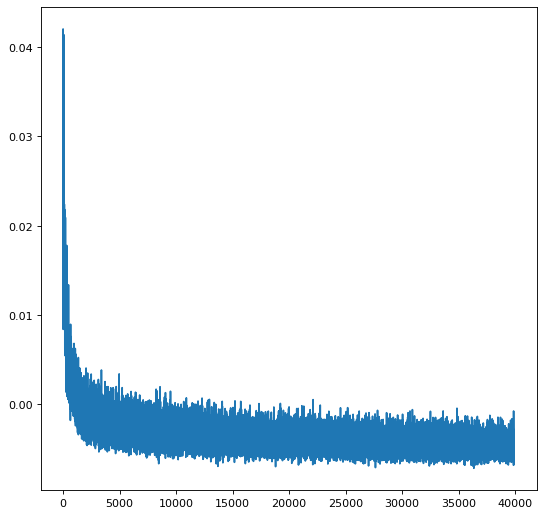

In [ ]:
#Training Loss vs batch number
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(losses[1:])
plt.show

In [ ]:
def dice(array1, array2, labels):
    """
    Computes the dice overlap between two arrays for a given set of integer labels.
    """
    dicem = np.zeros(len(labels))
    for idx, label in enumerate(labels):
        top = 2 * np.sum(np.logical_and(array1 == label, array2 == label))
        bottom = np.sum(array1 == label) + np.sum(array2 == label)
        bottom = np.maximum(bottom, np.finfo(float).eps)  # add epsilon
        dicem[idx] = top / bottom
    return dicem

In [ ]:
def register(target, moving, network, init_model_file, seg = False):
    '''registration function responsible for performing registration on given image-pair + [optional] segmentation'''

    import losses

    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
   
    atlas_t = np.load(target)
    atlas_vol_t = atlas_t['vol'][np.newaxis, ..., np.newaxis]
    atlas_seg_t = atlas_t['seg'][np.newaxis, ..., np.newaxis]
    vol_size = atlas_vol_t.shape[1:-1]
    
    # set up atlas and corresponding segmentation tensor

    input_fixed  = torch.from_numpy(atlas_vol_t).to(device).float()
    input_fixed  = input_fixed/255.0
    input_fixed  = input_fixed.permute(0, 3, 1, 2)

    input_fixed_seg  = torch.from_numpy(atlas_seg_t).to(device).float()
    input_fixed_seg  = input_fixed_seg/255.0
    input_fixed_seg  = input_fixed_seg.permute(0, 3, 1, 2)
    
    # set up Moving image and corresponding segmentation tensor
    atlas_m = np.load(moving)
    atlas_vol_m = atlas_m['vol_data'][np.newaxis, ..., np.newaxis]
    atlas_seg_m = atlas_m['seg'][np.newaxis, ..., np.newaxis]
    
    input_moving = torch.from_numpy(atlas_vol_m).to(device).float()
    input_moving = input_moving/255.0
    input_moving = input_moving.permute(0, 3, 1, 2)

    seg_moving = torch.from_numpy(atlas_seg_m).to(device).float()
    seg_moving = seg_moving/255.0
    seg_moving = seg_moving.permute(0, 3, 1, 2)    

    # loss functions
    sim_loss_MSE = losses.mse_loss
    sim_loss_CC = losses.ncc_loss
    grad_loss_fn = losses.gradient_loss
    dice_loss_fn = losses.diceLoss
    dice_hard = dice

    spatial=SpatialTransformer((256,256))
    spatial=spatial.to(device)

    # Set up model
    model = network
    model.to(device)
    model.load_state_dict(torch.load(init_model_file, map_location=lambda storage, loc: storage))

    # Error before registration
    initial_loss_MSE = sim_loss_MSE(input_moving, input_fixed) 
    initial_loss_CC = sim_loss_CC(input_moving, input_fixed) 

    fixed_seg = input_fixed_seg.to('cpu')
    fixed_seg = fixed_seg.detach().numpy()
    moving_seg = seg_moving.to('cpu')
    moving_seg = moving_seg.detach().numpy()

    intial_dice_hard = dice_hard(moving_seg, fixed_seg, [1]) 

    #Pass image-pair to model
    warp, flow = model(input_moving, input_fixed)

    # Error after registration
    recon_loss_MSE = sim_loss_MSE(warp, input_fixed) 
    recon_loss_CC = sim_loss_CC(warp, input_fixed) 
    loss_grad = 0.01*grad_loss_fn(flow)
    
    #Apply registration field to moving segmentation
    warp_seg = spatial(seg_moving,flow)

    if (seg == True):
      loss_dice = 0.01*dice_loss_fn(input_fixed_seg, warp_seg)
    else:
      loss_dice = 0

    warp_seg = warp_seg.to('cpu')
    warp_seg = warp_seg.detach().numpy()

    dice_score = dice_hard(warp_seg, fixed_seg, [1])   
    Total_Loss = recon_loss_MSE + loss_grad + loss_dice

    return warp, input_fixed, input_moving, recon_loss_MSE, initial_loss_MSE, recon_loss_CC, initial_loss_CC, flow ,warp_seg, input_fixed_seg, seg_moving, dice_score, intial_dice_hard, Total_Loss

In [ ]:
'''affine transformations''''

def translate(image,tx,ty):
  'translate() responsible for translation in x and y directions by given values (tx,ty)'
  rows,cols = image.shape
  affine_M = np.float32([[1,0,tx],[0,1,ty]]) #affine_Matrix generation 
  dst = cv2.warpAffine(image,affine_M,(cols,rows)) #warped image

  return dst, affine_M

def rotation(image,rot_Z):
  'rotation() responsible for rotation about z-axis by given values'
  rows,cols = image.shape
  
  affine_M = cv2.getRotationMatrix2D((cols/2,rows/2),rot_Z,1) #affine_Matrix generation 
  dst = cv2.warpAffine(image,affine_M,(cols,rows)) #warped image

  return dst, affine_M

In [ ]:
'''test image generation''''

path_to_folder='/content/drive/My Drive/2020/Thesis/Data/Chest/'
'''generate moving test image'''
patient_number=27
path_to_image=path_to_folder + 'Patient_' + str(patient_number) +'/tens(coronal)_img_'+ str(patient_number) + '.png'
test_image = cv2.imread(path_to_image,0)

path_to_seg=path_to_folder + 'Patient_' + str(patient_number) +'/normalised_seg_'+ str(patient_number) + '.png'
test_seg = cv2.imread(path_to_seg,0)

'''transformations'''
rotate=False
translation=False
rotate_translate=True

rotZ=0
tx=0
ty=0

if translation:
  vol_data, matrix=translate(test_image,tx,ty)
  seg, matrix_seg=translate(test_seg,tx,ty)
elif rotate:
  vol_data, matrix=rotation(test_image,rotZ)
  seg, matrix_seg=rotation(test_seg,rotZ)
elif rotate_translate:
  vol_data, matrix=translate(test_image,tx,ty)
  vol_data, matrix=rotation(vol_data,rotZ)
        
  seg, matrix_seg=translate(test_seg,tx,ty)
  seg, matrix_seg=rotation(seg,rotZ)  

test_image_dir = '/content/drive/My Drive/2020/Thesis/Data/Voxel_Testing/Siddon/Chest/'
np.savez(test_image_dir + 'test_image',vol_data=vol_data, seg=seg)


(-0.5, 255.5, 255.5, -0.5)

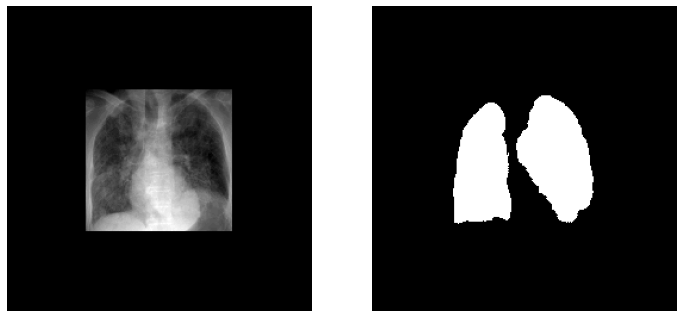

In [ ]:
'''Data_Check'''
test_vol_names = glob.glob(os.path.join(test_image_dir, '*.npz'))
Y = np.load(test_vol_names[0])['vol_data']
Y_seg = np.load(test_vol_names[0])['seg']

fig=plt.figure(figsize=(12, 12))
columns = 2
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(Y,cmap='gray')
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(Y_seg,cmap='gray')
plt.axis('off')

In [ ]:
'''Registration'''
target='/content/drive/My Drive/2020/Thesis/Data/atlas.npz'
moving='/content/drive/My Drive/2020/Thesis/Data/Voxel_Testing/Siddon/Chest/test_image.npz'
init_model_file='/content/drive/My Drive/2020/Thesis/Data/model_21_10_2020_CC_norm_segs/61_0.ckpt'
network=Net()
network.to(device)

Net(
  (conv_0): Conv2d(2, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_1): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_3): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (activation): LeakyReLU(negative_slope=0.2)
  (conv_0_dec): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_1_dec): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2_dec): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3_dec): Conv2d(48, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4_dec): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_5_dec): Conv2d(34, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample): Upsample(scale_factor=2.0, mode=nearest)
  (conv_vm2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_flo

In [ ]:
warped, fixed, move, loss_MSE, loss_I_MSE, loss_CC, loss_I_CC, flow, warp_seg, input_fixed_seg, seg_moving, dice_score, Initial_dice_score, Total_Loss=register(target, moving, network, init_model_file)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [ ]:
%timeit warped, fixed, move, loss_MSE, loss_I_MSE, loss_CC, loss_I_CC, flow, warp_seg, input_fixed_seg, seg_moving, dice_score, Initial_dice_score, Total_Loss=register(target, moving, network, init_model_file)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


10 loops, best of 3: 20.8 ms per loop


In [ ]:
'''export results''''
import csv
with open('MSE_proper_affine.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Patient", "Translation-x","Translation-y", "Rotation", "Segmentations",
                     "Error_MSE_before_reg", "Error_MSE_after_reg","Error_CC_before_reg",
                     "Error_CC_after_reg","Dice_Score_before_reg", "Dice_Score_after_reg", "time_to_reg(MSE)",
                    "singularities(MSE)", "" , "0<J<1(MSE)", "", "J>1(MSE)", ""])
    
    writer.writerow([3, tx, ty, rotZ, "Yes", loss_I_MSE.item() * 100, loss_MSE.item() * 100, loss_I_CC.item() * 100, loss_CC.item() * 100, Initial_dice_score.item(), dice_score.item(), str(time_to_reg) + "ms", singularity, str(singularity_percentage) + "%", shrunk, str(shrunk_percentage) + "%", expand, str(expand_percentage) + "%"])


In [ ]:
with open('MSE_proper_affine.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([3, tx, ty, rotZ, "Yes", loss_I_MSE.item() * 100, loss_MSE.item() * 100, loss_I_CC.item() * 100, loss_CC.item() * 100, Initial_dice_score.item(), dice_score.item(), str(time_to_reg) + "ms", singularity, str(singularity_percentage) + "%", shrunk, str(shrunk_percentage) + "%", expand, str(expand_percentage) + "%"])

In [ ]:
fixed=fixed.to('cpu')
move=move.to('cpu')

warped=warped.to('cpu')
warped=warped.detach().numpy()

array1=input_fixed_seg
array2=warp_seg

input_fixed_seg=input_fixed_seg.to('cpu')
seg_moving=seg_moving.to('cpu')

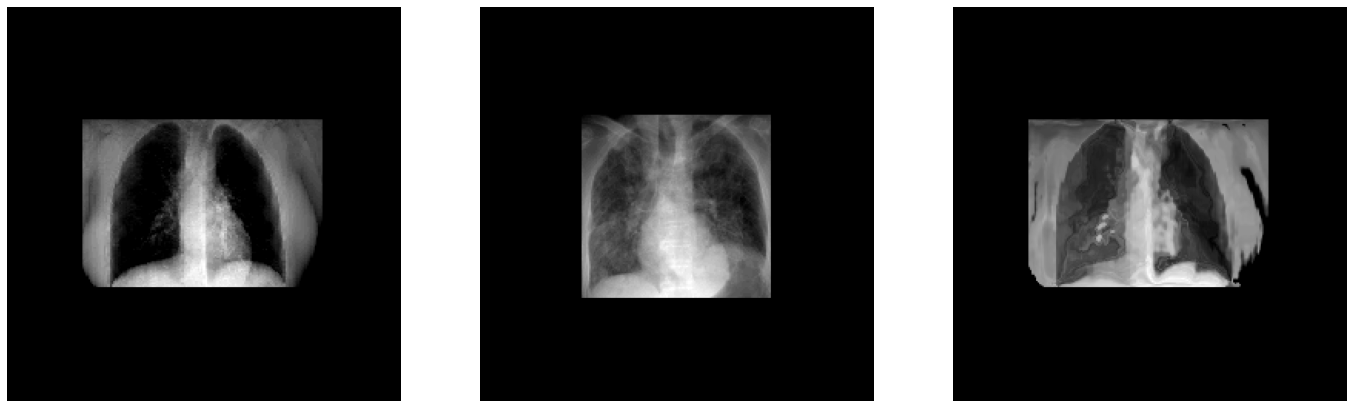

In [ ]:
'''Atlas, Moving, Warped plot'''

fig=plt.figure(figsize=(24, 24))
columns = 3
rows = 1
fig.add_subplot(rows, columns, 3)
plt.imshow(warped[0,0,:,:],cmap='gray')
plt.axis('off')
fig.add_subplot(rows, columns, 1)
plt.imshow(fixed[0,0,:,:],cmap='gray')
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(move[0,0,:,:],cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
print("MSE_loss (before registration):",loss_I_MSE.item())
print("MSE_loss (after registration):",loss_MSE.item())

MSE_loss (before registration): 0.0346047580242157
MSE_loss (after registration): 0.0030098017305135727


In [ ]:
print("CC_loss (before registration):",loss_I_CC.item())
print("CC_loss (after registration):",loss_CC.item())

CC_loss (before registration): -0.05623967945575714
CC_loss (after registration): -0.11761358380317688


In [ ]:
print("Dice_Score (before registration):",Initial_dice_score.item())
print("Dice_Score (after registration):",dice_score.item())

Dice_Score (before registration): 0.5002486943546381
Dice_Score (after registration): 0.8922655374268278


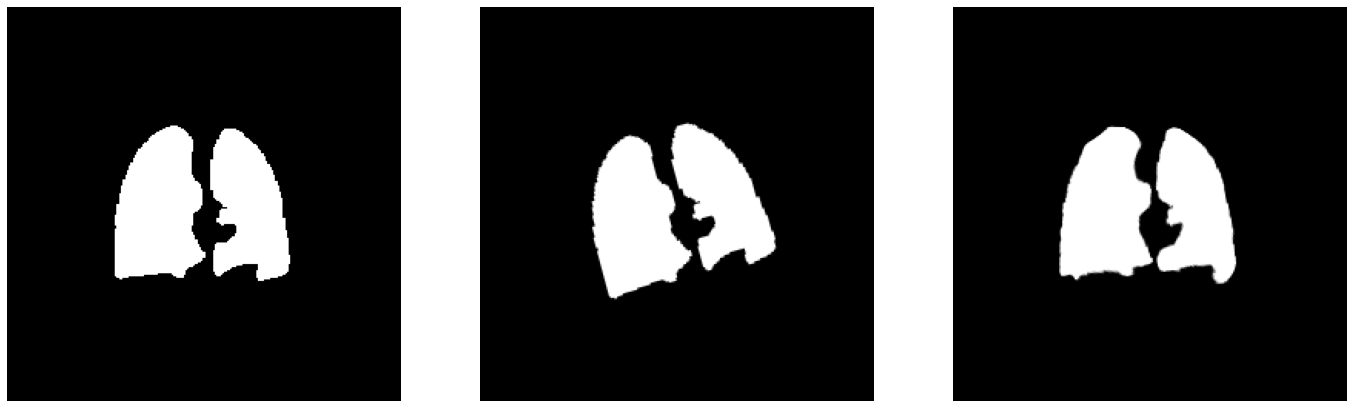

In [ ]:
'''Atlas, Moving, Warped plot (segmentation)'''

fig=plt.figure(figsize=(24, 24))
columns = 3
rows = 1
fig.add_subplot(rows, columns, 3)
plt.imshow(warp_seg[0,0,:,:],cmap='gray')
plt.axis('off')
fig.add_subplot(rows, columns, 1)
plt.imshow(input_fixed_seg[0,0,:,:],cmap='gray')
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(seg_moving[0,0,:,:],cmap='gray')
plt.axis('off')


plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


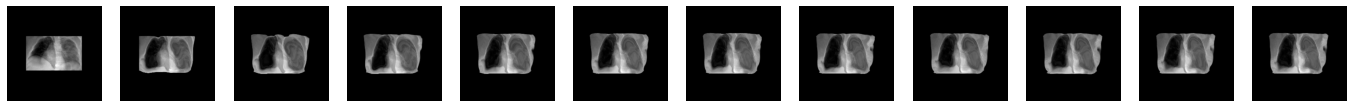

In [ ]:
fig=plt.figure(figsize=(24, 24))
for model in range(0,12):
  init_model_file='/content/drive/My Drive/2020/Thesis/Data/model_21_10_2020_MSE_norm_segs/' + str(model) + '_0.ckpt'
  warped, fixed, move, loss_MSE, loss_I_MSE, loss_CC, loss_I_CC, flow, warp_seg, input_fixed_seg, seg_moving, dice_score, Initial_dice_score, Total_Loss=register(target, moving, network, init_model_file)
  warped = warped.to('cpu')
  warped=warped.detach().numpy()

  fig.add_subplot(1, 12, model+1)
  plt.imshow(warped[0,0,:,:],cmap='gray',aspect='equal')
  plt.axis('off')

plt.show()

In [ ]:
!pip install pystrum

In [ ]:
!pip install neurite

In [ ]:
import pystrum.pynd.ndutils as nd
import neurite as ne

def jacobian_determinant(disp):
    """
    jacobian determinant of a displacement field.
    NB: to compute the spatial gradients, we use np.gradient.
    Parameters:
        disp: 2D or 3D displacement field of size [*vol_shape, nb_dims], 
              where vol_shape is of len nb_dims
    Returns:
        jacobian determinant (scalar)
    """

    # check inputs
    volshape = disp.shape[:-1]
    nb_dims = len(volshape)
    assert len(volshape) in (2, 3), 'flow has to be 2D or 3D'

    # compute grid
    grid_lst = nd.volsize2ndgrid(volshape)
    grid = np.stack(grid_lst, len(volshape))

    # compute gradients
    J = np.gradient(disp + grid)
    print(J)
   

    # 3D glow
    if nb_dims == 3:
        dx = J[0]
        dy = J[1]
        dz = J[2]

        # compute jacobian components
        Jdet0 = dx[..., 0] * (dy[..., 1] * dz[..., 2] - dy[..., 2] * dz[..., 1])
        Jdet1 = dx[..., 1] * (dy[..., 0] * dz[..., 2] - dy[..., 2] * dz[..., 0])
        Jdet2 = dx[..., 2] * (dy[..., 0] * dz[..., 1] - dy[..., 1] * dz[..., 0])

        return Jdet0 - Jdet1 + Jdet2

    else: # must be 2 
        
        dfdx = J[0]
        dfdy = J[1] 
        
        return dfdx[..., 0] * dfdy[..., 1] - dfdy[..., 0] * dfdx[..., 1]

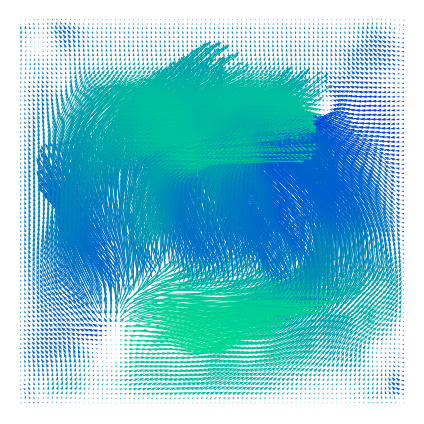

In [ ]:
'''Registration field display'''

flow=flow.to('cpu')
wf=(flow.permute(0,2,3,1))
wf=wf.detach().numpy()
ne.plot.flow([wf[0,...].squeeze()[::3,::3]], width=6);

In [ ]:
'''Jacobian determinant'''

flow=(flow.permute(0,2,3,1))
flow=flow.detach().numpy()

determinant=jacobian_determinant(flow[0,:,:,:])

In [ ]:
'''Jacobian details'''

singularity=0         # det(J)<0
shrunk=0              # 0<det(J)<1
unchanged=0           # det(J)=0
expand=0              # det(J)>1

for column in range(0,256):
  for row in range(0,256):
    if determinant[row][column]<0:
      singularity+=1
    elif 0<determinant[row][column]<1:
      shrunk+=1
    elif determinant[row][column]==0:
      unchanged+=1
    else:
      expand+=1  

print(singularity)
print(shrunk)
print(unchanged)
print(expand) 

singularity_percentage = round(singularity/(255**2) * 100, 2)
shrunk_percentage = round(shrunk/(255**2) * 100, 2)
expand_percentage = round(expand/(255**2) * 100, 2)

183
38417
0
26936
